In [1489]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import kernels, GaussianProcessRegressor
from scipy.stats import norm

if os.getcwd() == '/Users/cd8607/Documents/Fitting_Potential':
    pass
else:
    os.chdir('../')

whe = np.loadtxt('Potentials/W-He-Juslin.table',skiprows=6)[:,1:3]


def zbl(rij, Zi, Zj):
    
    e0 = 55.26349406e-4

    const = 1/(4*np.pi*e0)

    a = 0.46850/(Zi**0.23 + Zj**0.23)	

    x = rij/a

    x = x[:, np.newaxis]

    amplitude = np.array([0.18175, 0.50986, 0.28022, 0.02817])
    exponent = np.array([3.19980, 0.94229, 0.40290, 0.20162])

    phi = np.sum(amplitude * np.exp(-exponent * x), axis=1)
        
    return const*phi*(Zi*Zj/rij)

In [1490]:
class GP_BayesOpt():

    def __init__(self, x_test, y_test, n_knots = 4):

        self.n_knots = n_knots
        
        self.x_test = x_test
        self.y_test = y_test

    def rand_sample_points(self):

        x_knot = np.linspace(0.5, 4, self.n_knots).reshape(-1,1)
        y_knot = np.random.normal(loc = 0, scale = 1, size = (self.n_knots,1))

        return np.vstack([0.25,x_knot, 6]), np.vstack([0,y_knot,0])

    def gpr_fit(self, x = None, y = None):

        if x is None or y is None:
            
            x, y = self.rand_sample_points()

        kernel = kernels.ConstantKernel(1, constant_value_bounds='fixed')*kernels.RBF(1,length_scale_bounds='fixed')

        self.gpr = GaussianProcessRegressor(kernel, alpha = 1e-3).fit(x, y)
    

    def loss(self):

        y_predict = self.gpr.predict(self.x_test.reshape(-1,1))

        return np.linalg.norm(y_predict-self.y_test)/len(self.y_test)
    
    def bayes_opt(self, n_samples):
        
        n_rand_samples  = n_samples//2

        n_bayes_samples = n_samples - n_rand_samples

        x_samples = np.zeros((n_samples, self.n_knots + 2))
        y_samples = np.zeros((n_samples, self.n_knots + 2))

        loss_samples = np.zeros((n_samples,))

        for i in range(n_rand_samples):
            
            x_sample, y_sample = self.rand_sample_points()

            x_samples[i] = x_sample.flatten()

            y_samples[i] = y_sample.flatten()

            loss_samples[i] = self.loss()

        kernel = kernels.ConstantKernel(loss_samples[:n_rand_samples].mean(),constant_value_bounds='fixed') *\
                 kernels.RBF(10,length_scale_bounds='fixed')

        self.gpr_bayes = GaussianProcessRegressor(kernel).fit(y_samples[:n_rand_samples],loss_samples[:n_rand_samples])

        print(loss_samples[:n_rand_samples].min(), y_samples[loss_samples[:n_rand_samples].argmin()]) 

        

In [1491]:
x_test = whe[100:,0]
y_test = whe[100:,1] - zbl(whe[100:,0], 74, 2)

inst = GP_BayesOpt(x_test, y_test, 6)

inst.gpr_fit()

inst.loss()

0.054334396922324314

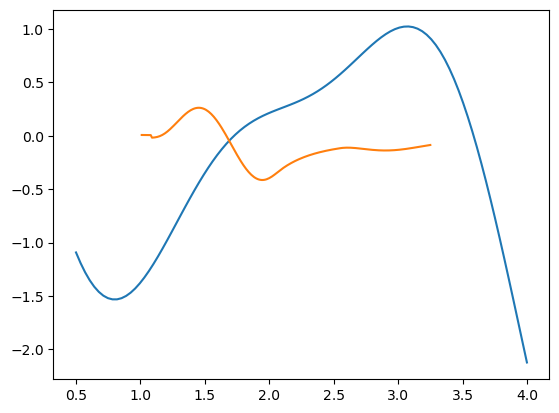

In [1492]:
x_predict = np.linspace(0.5,4,100)
y_predict = inst.gpr.predict(x_predict.reshape(-1,1))

plt.plot(x_predict,y_predict)

plt.plot(x_test, y_test)

In [1494]:
inst.bayes_opt(10000)

print(inst.gpr_bayes.log_marginal_likelihood())

print(inst.gpr_bayes.kernel_)


0.054334396922324314 [ 0.         -0.38719287 -0.90516159 -1.28848556  0.18039333 -1.59001429
  1.73065318  0.        ]
50930.80987340519
0.233**2 * RBF(length_scale=10)
